# Loading Models Notebook

In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import torch
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from lora_w2w import LoRAw2w
from utils import load_models, inference, unflatten
from diffusers import DiffusionPipeline 
from peft import PeftModel
from peft.utils.save_and_load import load_peft_weights
device = "cuda:0"

## Load Files

1) mean is 99648 dimensional tensor of the mean for each parameter in the original LoRA space.
2) std is 99648 dimensional tensor of the standard deviation for each parameter in the original LoRA space.
3) v is 99648x10000 dimensional tensor used to project or unproject the weights onto principal component representation in w2w space or to unproject back into the LoRA space.
4) proj is a 64974x1000 dimensional tensor where each row is a 1000 dimensional principal component representation for each identity-encoding model in our dataset of weights. 

In [2]:
mean = torch.load("../files/mean.pt").bfloat16().to(device)
std = torch.load("../files/std.pt").bfloat16().to(device)
v = torch.load("../files/V.pt").bfloat16().to(device)
proj = torch.load("../files/proj_1000pc.pt").bfloat16().to(device)

## Loading a Model in *w2w* Space

### Load Base Models

In [3]:
unet, vae, text_encoder, tokenizer, noise_scheduler = load_models(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


Load weights for a model in low-dimensional *w2w* space (represented by its principal component coefficients)

In [4]:
weights0 = torch.load("../output/sample1_w2w/w2wmodel.pt").to(device)

Initialize network. Here, our loaded network is represented by 1000 coefficients, so we load in the first 1000 dimensions of the *v* projection/unprojection matrix.

In [5]:
network = LoRAw2w(unet = unet,
                proj = weights0, 
                mean = mean, 
                std = std, 
                v = v[:,:1000],
                rank=1,
                multiplier=1.0,
                alpha=27,
                train_method="xattn-strict",
                ).to(device, dtype=torch.bfloat16)

### Inference

100%|██████████| 51/51 [00:05<00:00,  9.56it/s]


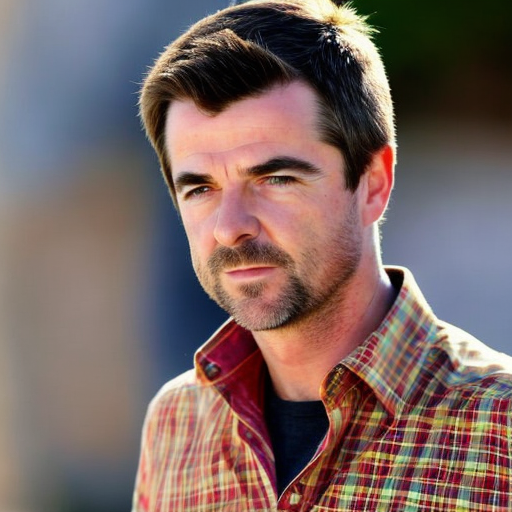

In [6]:
#inference parameters
prompt = "sks person" 
negative_prompt = "low quality, blurry, unfinished" 
guidance_scale = 3.0
seed = 5
ddim_steps = 50
# random seed generator
generator = torch.Generator(device=device)

#run inference
image = inference(network, unet, vae, text_encoder, tokenizer, prompt, negative_prompt, guidance_scale, noise_scheduler, ddim_steps, seed, generator, device)

### display image
image = image.detach().cpu().float().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image.show()

# Loading a Model into Diffusers Pipeline

In [7]:
pipe = DiffusionPipeline.from_pretrained("stablediffusionapi/realistic-vision-v51", 
                                         torch_dtype=torch.float16,safety_checker = None,
                                         requires_safety_checker = False).to(device)
   
pipe.unet = PeftModel.from_pretrained(pipe.unet, "../output/sample1_diffusers/unet", adapter_name="identity1")
adapters_weights1 = load_peft_weights("../output/sample1_diffusers/unet", device="cuda:0")
pipe.unet.load_state_dict(adapters_weights1, strict = False)
pipe.to(device)
print("")

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


100%|██████████| 50/50 [00:03<00:00, 12.91it/s]


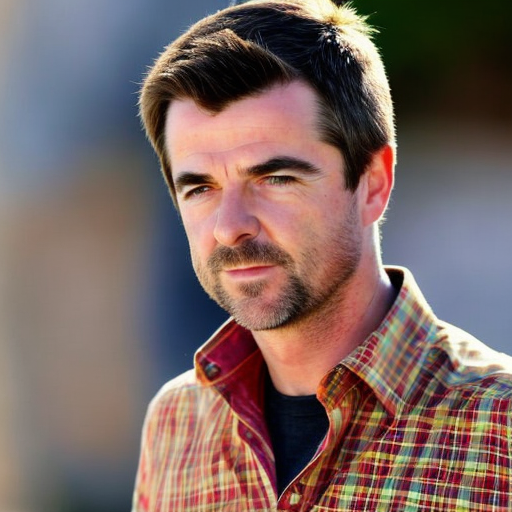

In [8]:
#random seed generator
generator = torch.Generator(device=device)
generator = generator.manual_seed(5)
latents = torch.randn(
        (1, pipe.unet.in_channels, 512 // 8, 512 // 8),
        generator = generator,
        device = device
    ).half()

#inference parameters
prompt = "sks person"
negative_prompt = "low quality, blurry, unfinished"
guidance_scale = 3.0
ddim_steps = 50
#run inference
image = pipe(prompt, num_inference_steps=ddim_steps, guidance_scale=guidance_scale,  negative_prompt=negative_prompt, latents = latents ).images[0]
image